In [ ]:
# http://arxiv.org/abs/1507.06947
# http://arxiv.org/pdf/1507.06947v1.pdf

# We use 80-dimensional log mel filterbank energy features computed
# every 10ms on 25ms windows. We obtained significant
# improvements by increasing the number of filterbanks from 40
# up to 80, but only present results for the latter.

# scikits.talkbox -
# https://pypi.python.org/pypi/scikits.talkbox
# https://github.com/cournape/talkbox
# /home/ubuntu/miniconda2/bin/conda install -c https://conda.anaconda.org/davidbgonzalez scikits.talkbox

# python_speech_features
#
# http://python-speech-features.readthedocs.org/en/latest/
# https://github.com/jameslyons/python_speech_features

# http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

In [9]:
cat mahasamoot-20070718-cc/etc/PROMPTS

mahasamoot-20070718-cc/mfc/cc-01 WELL HERE'S A STORY FOR YOU SARAH PERRY WAS A VETERINARY NURSE
mahasamoot-20070718-cc/mfc/cc-02 WHO HAD BEEN WORKING DAILY AT AN OLD ZOO IN A DESERTED DISTRICT OF THE TERRITORY
mahasamoot-20070718-cc/mfc/cc-03 SO SHE WAS VERY HAPPY TO START A NEW JOB AT A SUPERB PRIVATE PRACTICE
mahasamoot-20070718-cc/mfc/cc-04 IN NORTH SQUARE NEAR THE DUKE STREET TOWER
mahasamoot-20070718-cc/mfc/cc-05 THAT AREA WAS MUCH NEARER FOR HER AND MORE TO HER LIKING
mahasamoot-20070718-cc/mfc/cc-06 EVEN SO ON HER FIRST MORNING SHE FELT STRESSED
mahasamoot-20070718-cc/mfc/cc-07 SHE ATE A BOWL OF PORRIDGE CHECKED HERSELF IN THE MIRROR
mahasamoot-20070718-cc/mfc/cc-08 AND WASHED HER FACE IN A HURRY THEN SHE PUT ON A PLAIN YELLOW DRESS
mahasamoot-20070718-cc/mfc/cc-09 AND A FLEECE JACKET PICKED UP HER KIT AND HEADED FOR WORK
mahasamoot-20070718-cc/mfc/cc-10 WHEN SHE GOT THERE THERE WAS A WOMAN WITH A GOOSE WAITING FOR HER
mahasamoot-20070718-cc/mfc/cc-11 THE WOMAN GAVE SARAH AN OFF

In [10]:
ls mahasamoot-20070718-cc/wav/cc-01.wav

cc-01.wav  cc-07.wav  cc-13.wav  cc-19.wav  cc-25.wav  cc-31.wav  cc-37.wav
cc-02.wav  cc-08.wav  cc-14.wav  cc-20.wav  cc-26.wav  cc-32.wav  cc-38.wav
cc-03.wav  cc-09.wav  cc-15.wav  cc-21.wav  cc-27.wav  cc-33.wav  cc-39.wav
cc-04.wav  cc-10.wav  cc-16.wav  cc-22.wav  cc-28.wav  cc-34.wav
cc-05.wav  cc-11.wav  cc-17.wav  cc-23.wav  cc-29.wav  cc-35.wav
cc-06.wav  cc-12.wav  cc-18.wav  cc-24.wav  cc-30.wav  cc-36.wav


In [1]:
import wave, numpy, struct

def read_wave(fn):
    # Open
    w = wave.open(fn,"rb")
    p = w.getparams()
    f = p[3] # number of frames
    s = w.readframes(f)
    w.close()
    return (numpy.fromstring(s, numpy.int16), p)

arr, params = read_wave("mahasamoot-20070718-cc/wav/cc-01.wav")

In [5]:
import IPython
IPython.display.Audio("mahasamoot-20070718-cc/wav/cc-01.wav")

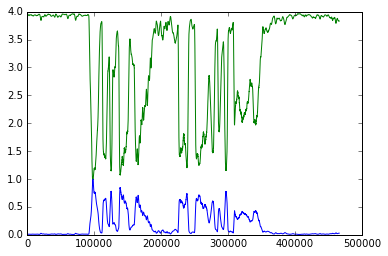

In [16]:
import scipy.signal
import numpy as np

def rerange(arr, M=4,
            window=scipy.signal.get_window(('gaussian', 500), 2001)):
    """
    Change dynamic range of input sound array, using a quadratic curve.

    M:
    Silence multiple -- multiply values near silence by this amount.
    Values near maximum sound in arr get multiplied by 1.0
    So choosing M < 1.0 increases dynamic variation in the output.
    
    Quadratic curve is chosen such that turning point is at maximum
    sound. i.e. values near maximum sound do not change much,
    whether M < 1.0 or M > 1.0.

    window:
    kernel for convolution. Default Gaussian with standard deviation
    500 elements centered in a window of 2001 elements.
    """

    window /= np.sum(window) # So weights in window sum to 1.0.
    # Compute weighted sum of window centered at each element.
    means = scipy.signal.fftconvolve(abs(arr), window, 'same')

    # the following handles first half-window and last half-window
    # of means, who get only half the convolution and are therefore
    # artificially small.
    edge_weights = scipy.signal.convolve(np.ones(window.size), window, 'same')
    size2 = int(window.size / 2)
    means[:size2] /= edge_weights[:size2]
    means[-size2:] /= edge_weights[-size2:]

    means /= np.max(means) # Normalize to between 0.0 and 1.0
    
    # The following quadratic curve has value M when means = 0.0,
    # 1.0 when means = 1.0, and has gradient 0 when means = 1.0.
    multipliers = (M - 1) * means**2 + 2 * (1 - M) * means + M

    # Make sure output max loudness doesn't exceed input's.
    maxval = np.abs(arr).max()
    narr = np.clip(arr * multipliers, -maxval, maxval)
    
    return (means, multipliers, np.round(narr))

means, multipliers, narr = rerange(arr)

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.plot(means)
plt.plot(multipliers)
plt.show()

In [34]:
import numpy as np
from scipy.fftpack import fft

def genSine(A, f, phi, fs, t):
    """
    Inputs:
        A (float) =  amplitude of the sinusoid
        f (float) = frequency of the sinusoid in Hz
        phi (float) = initial phase of the sinusoid in radians
        fs (float) = sampling frequency of the sinusoid in Hz
        t (float) =  duration of the sinusoid (is second)
    Output:
        The function should return a numpy array
        x (numpy array) = The generated sinusoid
    """
    ## Your code here

    return A * np.cos(2 * np.pi * f * np.arange(fs * t) / fs + phi)

#
# if M >= 10,000, then you have a full second's worth and the frequencies that
# you see in the fft are 80, 200, -80, and -200.  -80 shows up as 10000-80 = 9920
#
# if M = 250, you see frequencies of 2, 5, -2, -5 (-2 really means 250-2 = 248)
#
M = 250
epsilon = 1e-6

x1 = genSine(1, 80, 0, 10000, 1)
x2 = genSine(1, 200, 0, 10000, 1)
x = x1 + x2
X = fft(x[:M])
(abs(X) >= epsilon).nonzero()

(array([  2,   5, 245, 248]),)

In [7]:
import features
import scikits.talkbox

ValueError: numpy.dtype does not appear to be the correct type object

In [1]:
from features import mfcc
from features import logfbank
import scipy.io.wavfile as wav

(rate,sig) = wav.read("mahasamoot-20070718-cc/wav/cc-01.wav")
mfcc_feat = mfcc(sig,rate)
fbank_feat = logfbank(sig,rate)

print(fbank_feat[1:3,:])

[[ 5.73827022  6.0653399   6.9593735   6.96706208  5.13788865  5.07660577
   6.69684548  7.39514354  5.92802248  8.01187523  7.4348068   6.87181108
   7.19237798  7.24834167  7.4598335   7.67008845  7.2520767   7.40734219
   6.20355878  1.85789758  1.74957036  1.9203534   2.54773543  2.9544192
   2.79217738  3.14088545]
 [ 5.49912949  4.27606041  6.07521522  6.11002973  5.4129759   6.02795636
   5.86167647  7.02782372  6.52090321  7.15379798  7.96688637  7.80459636
   7.55922326  7.17737509  7.47250546  7.0310183   7.31108718  7.3819632
   5.2536345   2.22057956  2.32706861  2.7059542   3.18988143  3.52044221
   3.51107169  3.95010181]]


In [12]:
rate

# rate = 48kHz
# so if we want 25ms frames, 0.025 * 48000 = 1200 samples per frame
# frame step is 10ms, 0.01 * 48000 = 480 samples per step

48000

In [2]:
len(sig)

465920

In [4]:
465920 / 48000.0 # length of the clip in seconds = 9.71s

9.706666666666667

In [7]:
465920.0 / 480.0 # number of frames = 971

970.6666666666666

In [9]:
len(mfcc_feat)

970

In [11]:
mfcc_feat.shape

(970, 13)

In [12]:
print(mfcc_feat[1:3,:])

[[ 10.00459852  16.05354679 -26.44584878   6.67841989  14.75827795
  -18.33932414  23.12337806  -4.15974695 -19.58451088   6.38292476
  -19.57496402  -7.67690585  -0.9882703 ]
 [  9.92862595  11.49171842 -27.00146572  -1.88439453  14.91039861
  -17.26411341  14.1148817   -6.65464395 -16.15117607  14.66504025
   -7.59183777  -7.19070096   8.12464832]]


In [13]:
fbank_feat.shape

(970, 26)

In [ ]:
# search for "speech reconstruction from mel-frequency cepstral coefficients"

# D Chazan 2000
# Uses MFCC and pitch frequency
# http://www1.icsi.berkeley.edu/~dpwe/research/etc/icassp2000/pdf/716_22.PDF

# Milner and Shao
# Uses a source filter model
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.62.1968&rep=rep1&type=pdf

# Boucheron 2008
# 
# http://www.ece.nmsu.edu/~pdeleon/Research/Publications/ICSES_2008.pdf

# Ramabadran 2001
# uses voicing class and pitch period
# http://perso.telecom-paristech.fr/~chollet/Biblio/Congres/Audio/Eurospeech01/CDROM/papers/page1859.pdf

